<a href="https://colab.research.google.com/github/neuranna/labels-and-categories/blob/master/Labels_%26_Categories_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install arviz
!pip install pymc3 --upgrade

Requirement already up-to-date: pymc3 in /usr/local/lib/python3.6/dist-packages (3.8)


In [0]:
import pymc3 as pm
import numpy as np
from scipy import stats
import math
import theano
import theano.tensor as tt
import pickle
import pandas as pd
import matplotlib.pyplot as plt

##Generate category exemplars

Each exemplar is associated with a pair of two continuous values (one value per dimension). 

The exemplars fall into one of the two categories; the categories differ on one dimension but not the other. The values for the two dimensions are uncorrelated.

In [0]:
N_exemplars = 16    # total

# values within a single dimension are uniformly spaced
values_onedim = np.linspace(-2,2,num=int(math.sqrt(N_exemplars)))
dim1, dim2 = np.meshgrid(values_onedim, values_onedim)
dim1_all = dim1.flatten()
dim2_all = dim2.flatten()

# exemplar 1 from cat 1 has features cat1['diagnostic_dim'][0] 
# and cat1['non-diagnostic_dim'][0]
cat1 = {'diagnostic_dim': dim2_all[0:N_exemplars//2], 
        'non_diagnostic_dim': dim1_all[0:N_exemplars//2]}
cat2 = {'diagnostic_dim': dim2_all[N_exemplars//2:], 
        'non_diagnostic_dim': dim1_all[N_exemplars//2:]}

## Model 

**Specify the model.**

Shape and material bias are parameters specifying a prior belief about the diagnosticity of a given dimension. In this simulation, we assume that dimension 1 is diagnostic of category membership and test three different models:
- Right bias: dim1 bias param = 10, dim2 bias param = 1
- No bias: dim1 bias param = 10, dim2 bias param = 10
- Wrong bias: dim1 bias param = 1, dim2 bias param = 10

The bias parameters determine the pattern of sampling category means for a given dimension. If the bias is high, the means are likely to be highly correlated (i.e. the dimension does not help distinguish the categories). 

We control the relationship between the bias parameters and the correlation values used for sampling using the *correlation_param*. 


In [0]:
dim1_bias_param = 10   #@param {type:"number"}
dim2_bias_param = 1    #@param {type:"number"}
bias_params = np.array([dim1_bias_param, dim2_bias_param])  

with pm.Model() as model:

  correlation_param = 10    #@param {type:"number"} # controls the correlation transform 
  std = 1             # assumed to be the same for both dimensions

  # 1. Specify the distribution from which to sample correlation values
  v = pm.Gamma('v', alpha=bias_params, beta=np.ones(2), shape=(2,))
  # substract from 1 to reflect the intuition that higher weight -> 
  # dimension is more likely to be diagnostic of category
  dim_bias = pm.Deterministic('dim_bias', 1 - v / v.sum())

  dim_bias_transform = pm.Deterministic('dim_bias_transform', 
                                        dim_bias**(1/correlation_param))

  # 2. for each feature dimension:
  #   - compute correlation matrix between sampled category means
  #   - compute covariance matrix
  #   - sample category means using the covariance matrix
  #   - sample category variance

  # feature dimension 1 (shape)
  correlation_coefficient_dim1 = dim_bias_transform[0]*2-1
  corr_dim1 = pm.math.stack(
      pm.math.stack([pm.math.constant(1), correlation_coefficient_dim1]),
      pm.math.stack([correlation_coefficient_dim1, pm.math.constant(1)]))
  cov_dim1 = corr_dim1 * np.outer(std, std)
  category_means_dim1 = pm.MvNormal('category_means_dim1', mu=np.zeros(2), 
                                    cov=cov_dim1, shape=(2))
  sigma_dim1 = pm.TruncatedNormal('sigma_dim1', mu=0, sigma=1, lower=0, 
                                  shape=(2))

  # feature dimension 2 (material)
  correlation_coefficient_dim2 = dim_bias_transform[1]*2-1
  corr_dim2 = pm.math.stack(
      pm.math.stack([pm.math.constant(1), correlation_coefficient_dim2]),
      pm.math.stack([correlation_coefficient_dim2, pm.math.constant(1)]))
  cov_dim2 = corr_dim2 * np.outer(std, std)
  category_means_dim2 = pm.MvNormal('category_means_dim2', mu=np.zeros(2), 
                                    cov=cov_dim2, shape=(2,))
  sigma_dim2 = pm.TruncatedNormal('sigma_dim2', mu=0, sigma=1, lower=0, 
                                  shape=(2,))

**Fit the data**

The model is presented with data over multiple learning blocks, and its performance is evaluated after each block. 

In [7]:
# Fit the data
N_blocks = 4          #@param {type:"number"}
traces = []
traces_pred = []
test_items_dim1 = []
test_items_dim2 = []

for b in range(N_blocks):
  print("Running block %s" % (b+1))
  # The learners are exposed to the same data in each block
  # Here, dimension 1 is diagnostic of category membership
  cat1_data_dim1 = cat1['diagnostic_dim']
  cat1_data_dim2 = cat1['non_diagnostic_dim']
  cat2_data_dim1 = cat2['diagnostic_dim']
  cat2_data_dim2 = cat2['non_diagnostic_dim']
  test_items_dim1.append(np.concatenate((cat1['diagnostic_dim'], 
                                         cat2['diagnostic_dim'])))
  test_items_dim2.append(np.concatenate((cat1['non_diagnostic_dim'], 
                                         cat2['non_diagnostic_dim'])))

  sigma_p = 1    # perceptual noise

  # Condition the model on the observations and estimate
  with model:
    cat_1_observed_dim1 = pm.Normal(f'cat_1_observed_dim1_block{b}', 
                                    mu=category_means_dim1[0], 
                                    sigma=sigma_dim1[0]+sigma_p, 
                                    observed=cat1_data_dim1)
    cat_2_observed_dim1 = pm.Normal(f'cat_2_observed_dim1_block{b}', 
                                    mu=category_means_dim1[1], 
                                    sigma=sigma_dim1[1]+sigma_p, 
                                    observed=cat2_data_dim1)
    cat_1_observed_dim2 = pm.Normal(f'cat_1_observed_dim2_block{b}', 
                                    mu=category_means_dim2[0], 
                                    sigma=sigma_dim2[0]+sigma_p, 
                                    observed=cat1_data_dim2)
    cat_2_observed_dim2 = pm.Normal(f'cat_2_observed_dim2_block{b}', mu=category_means_dim2[1], sigma=sigma_dim2[1]+sigma_p, observed=cat2_data_dim2)

    traces.append(pm.sample(2000, tune=500, chains=2, target_accept=0.95))

Running block 1


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/usr/local/lib/python3.6/dist-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/usr/local/lib/python3.6/dist-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/usr/local/lib/python3.6/dist-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead o

Running block 2


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/usr/local/lib/python3.6/dist-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/usr/local/lib/python3.6/dist-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Sequential sampling (2 chains in 1 job)
NUTS: [sigma_dim2, category_means_dim2, sigma_dim1, category_means_dim1, v]
Sampling chain 1, 33 divergences: 100%|██████████| 2500/2500 [01:14<00

Running block 3


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/usr/local/lib/python3.6/dist-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/usr/local/lib/python3.6/dist-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Sequential sampling (2 chains in 1 job)
NUTS: [sigma_dim2, category_means_dim2, sigma_dim1, category_means_dim1, v]
Sampling chain 1, 1,134 divergences: 100%|██████████| 2500/2500 [00:38

Running block 4


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/usr/local/lib/python3.6/dist-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/usr/local/lib/python3.6/dist-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Sequential sampling (2 chains in 1 job)
NUTS: [sigma_dim2, category_means_dim2, sigma_dim1, category_means_dim1, v]
Sampling chain 1, 28 divergences: 100%|██████████| 2500/2500 [01:08<00

**Examine the traceplot for the last block**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f315b583940>,
      dtype=object)

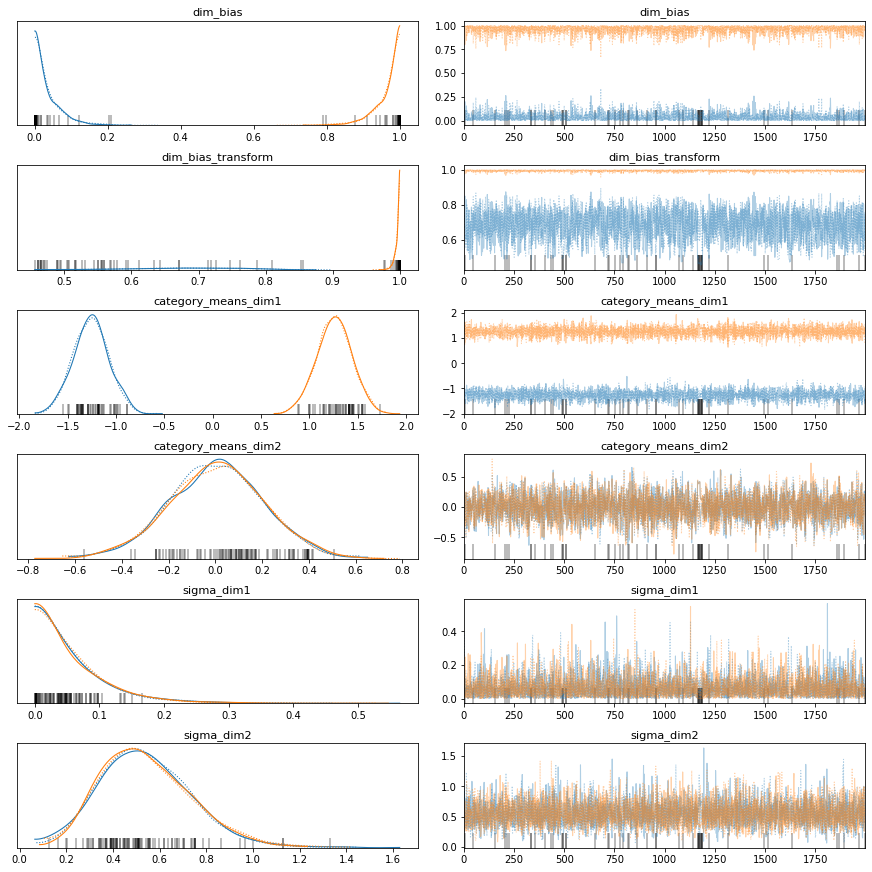

In [8]:
pm.traceplot(traces[-1], var_names=['dim_bias', 'dim_bias_transform', 'category_means_dim1', 'category_means_dim2', 'sigma_dim1', 'sigma_dim2'], compact=True)

**Examine estimates of category means over time**

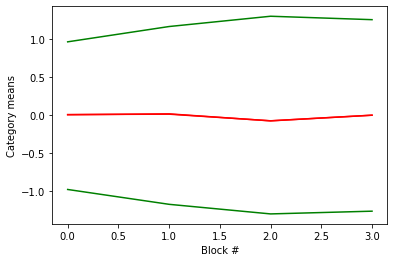

In [9]:
means_cat1_dim1 = []
means_cat1_dim2 = []
means_cat2_dim1 = []
means_cat2_dim2 = []
for trace in traces:
  df = pm.summary(trace)
  means_cat1_dim1.append(df['mean']['category_means_dim1[0]'])
  means_cat2_dim1.append(df['mean']['category_means_dim1[1]'])
  means_cat1_dim2.append(df['mean']['category_means_dim2[0]'])
  means_cat2_dim2.append(df['mean']['category_means_dim2[1]'])
plt.plot(range(N_blocks), means_cat1_dim1, color='g')
plt.plot(range(N_blocks), means_cat2_dim1, color='g')
plt.plot(range(N_blocks), means_cat1_dim2, color='r')
plt.plot(range(N_blocks), means_cat2_dim2, color='r')
plt.xlabel("Block #")
_ = plt.ylabel("Category means")

## Model Predictions 

In [0]:
def predict_labels(model_trace, test_dim1, test_dim2):
  data_length = len(test_dim1)
  df = pm.summary(model_trace)
  sigma_p = 1    # perceptual noise

  with pm.Model() as prediction_model:
    # sample the means and sigmas for each category 
    means_dim1 = pm.MvNormal('mean_dim1', mu=np.array([df['mean']['category_means_dim1[0]'], 
                                                       df['mean']['category_means_dim1[1]']]),
                             cov=np.array([[df['sd']['category_means_dim1[0]']**2,0],
                                           [0,df['sd']['category_means_dim1[1]']**2]]),
                             shape=(2))
    means_dim2 = pm.MvNormal('mean_dim2', mu=np.array([df['mean']['category_means_dim2[0]'], 
                                                       df['mean']['category_means_dim2[1]']]),
                             cov=np.array([[df['sd']['category_means_dim2[0]']**2,0],
                                           [0,df['sd']['category_means_dim2[1]']**2]]),
                             shape=(2))
    sigmas_dim1 = pm.MvNormal('sigmas_dim1', mu=np.array([df['mean']['sigma_dim1[0]'], 
                                                       df['mean']['sigma_dim1[1]']]),
                             cov=np.array([[df['sd']['sigma_dim1[0]']**2,0],
                                           [0,df['sd']['sigma_dim1[1]']**2]]),
                             shape=(2))
    sigmas_dim2 = pm.MvNormal('sigmas_dim2', mu=np.array([df['mean']['sigma_dim2[0]'], 
                                                       df['mean']['sigma_dim2[1]']]),
                             cov=np.array([[df['sd']['sigma_dim2[0]']**2,0],
                                           [0,df['sd']['sigma_dim2[1]']**2]]),
                             shape=(2))
    # sample the exemplars
    c = pm.Bernoulli('category_posterior', p=0.5, shape=data_length)
    test_item_dim1 = pm.Normal('test_item_dim1', mu=means_dim1[c], sigma=sigmas_dim1[c]+sigma_p, 
                              shape=data_length, observed=test_dim1)
    test_item_dim2 = pm.Normal('test_item_dim2', mu=means_dim2[c], sigma=sigmas_dim2[c]+sigma_p, 
                              shape=data_length, observed=test_dim2)
    trace_pred = pm.sample(2000, tune=500, chains=2)

  return trace_pred

In [11]:
traces_pred = []
for b in range(N_blocks):
  traces_pred.append(predict_labels(traces[b], 
                                    test_items_dim1[b],
                                    test_items_dim2[b]))

Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [sigmas_dim2, sigmas_dim1, mean_dim2, mean_dim1]
>BinaryGibbsMetropolis: [category_posterior]
Sampling chain 1, 0 divergences: 100%|██████████| 2500/2500 [00:13<00:00, 190.48it/s]
Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [sigmas_dim2, sigmas_dim1, mean_dim2, mean_dim1]
>BinaryGibbsMetropolis: [category_posterior]
Sampling chain 1, 0 divergences: 100%|██████████| 2500/2500 [00:12<00:00, 196.77it/s]
Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [sigmas_dim2, sigmas_dim1, mean_dim2, mean_dim1]
>BinaryGibbsMetropolis: [category_posterior]
Sampling chain 1, 0 divergences: 100%|██████████| 2500/2500 [00:12<00:00, 202.94it/s]
Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [sigmas_dim2, sigmas_dim1, mean_dim2, mean_dim1]
>BinaryGibbsMetropolis: [category_posterior]
Sampling chain 1, 0 divergences: 100%|██████████| 2500/2500 [00:12<00:00, 200.23it/s]


### Simulate participant-level predictions

In [0]:
N_participants = 80
block_accuracy = np.zeros(shape=N_blocks)
for b in range(N_blocks):
  df = pm.summary(traces_pred[b], var_names=['category_posterior'])
  df['predicted labels'] = np.random.binomial(n=N_participants, p=df['mean'])
  df['true labels'] = np.hstack([np.zeros(8), np.ones(8)*N_participants])
  df['accuracy'] = 1-np.abs(df['predicted labels']-df['true labels'])/N_participants
  block_accuracy[b] = np.sum(df['accuracy'])/len(df)

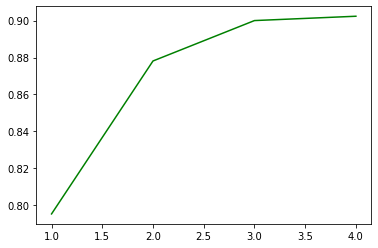

In [13]:
plt.plot(range(1,len(block_accuracy)+1), block_accuracy, color='g')

### Save results

In [14]:
%%bash
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit 
rm -rf labels-and-categories/
git clone https://github.com/neuranna/labels-and-categories.git

Cloning into 'labels-and-categories'...


In [0]:
# save the results
results_all = dict()
results_all['bias_params'] = bias_params
results_all['traces'] = traces
results_all['traces_pred'] = traces_pred
results_all['block_accuracy'] = block_accuracy

filename = f'labels-and-categories/modelfiles/results_dim1bias{bias_params[0]}_dim2bias{bias_params[1]}_corrparam{correlation_param}'
with open(filename,'wb') as f:
  pickle.dump(results_all, f)